In [1]:
import pandas as pd
import seaborn as sns
from sqlite3 import connect
import matplotlib.pyplot as plt

In [2]:
conn = connect("../data.db")
df = pd.read_sql("SELECT * FROM data", conn)
df

,algorithm,mixer,ansatz,optimizer,depth,cost,valid,graph,iteration,optimal,time_sec
0,vqe,None,two_local,spsa,1,61,1,1,1,54,210.552168
1,vqe,None,two_local,spsa,1,64,1,1,2,54,211.433584
2,vqe,None,two_local,spsa,1,69,1,1,3,54,211.039313
3,vqe,None,two_local,spsa,1,64,1,1,4,54,215.931236
4,vqe,None,two_local,spsa,1,72,1,1,5,54,214.023640
...,...,...,...,...,...,...,...,...,...,...,...
3116,vqe,None,pauli_two_design,slsqp,4,39,1,3,3,37,18425.325428
3117,vqe,None,pauli_two_design,slsqp,4,47,1,3,5,37,19739.729078
3118,vqe,None,pauli_two_design,slsqp,5,54,1,3,1,37,27521.079957
3119,vqe,None,pauli_two_design,slsqp,5,39,1,3,3,37,10840.461980


In [3]:
df_vqe = df[df["algorithm"] == "vqe"]
df_qaoa = df[df["algorithm"] == "qaoa"]

In [4]:
custom_palette_opt = {
    "spsa": "blue",
    "powell": "orange",
    "cobyla": "red",
    "slsqp": "green",
}

custom_palette_opt_light = {
    "spsa": "cornflowerblue",
    "powell": "orange",
    "cobyla": "indianred",
    "slsqp": "mediumseagreen",
}

## Factibilidade

In [5]:
def calculate_fact_ratio(df, vqa):
    circuit_type = "mixer" if vqa == "qaoa" else "ansatz"
    data = []
    for circuit in df[circuit_type].unique():
        df_circuit = df.query(f"{circuit_type} == '{circuit}'")
        for opt in df_circuit["optimizer"].unique():
            df_opt = df_circuit.query(f"optimizer == '{opt}'")
            for depth in df_opt["depth"].unique():
                df_depth = df_opt.query(f"depth == {depth}")
                total = len(df_depth)
                feasible = len(df_depth.query("valid == 1"))
                if total == 0:
                    continue
                data.append({
                    circuit_type: circuit,
                    "optimizer": opt,
                    "depth": depth,
                    "feasibility_ratio": feasible / total
                })
    return pd.DataFrame(data)

qaoa_feas_ratio = calculate_fact_ratio(df_qaoa, "qaoa")
vqe_feas_ratio = calculate_fact_ratio(df_vqe, "vqe")

In [32]:
qaoa_feas_ratio.sort_values(by="feasibility_ratio", ascending=False).head(10)

,mixer,optimizer,depth,feasibility_ratio
30,swap_ring_mixer,cobyla,1,1.000000
65,full_mixer,powell,1,1.000000
68,full_mixer,powell,4,1.000000
8,ring_mixer,powell,4,0.933333
76,full_mixer,slsqp,2,0.933333
74,full_mixer,cobyla,5,0.933333
73,full_mixer,cobyla,4,0.933333
72,full_mixer,cobyla,3,0.933333
40,parity_ring_mixer,spsa,1,0.933333
99,row_swap_mixer,slsqp,5,0.933333


In [34]:
vqe_feas_ratio.sort_values(by="feasibility_ratio", ascending=False).head(10)

,ansatz,optimizer,depth,feasibility_ratio
1,two_local,spsa,2,1.0
2,two_local,spsa,3,1.0
3,two_local,spsa,4,1.0
4,two_local,spsa,5,1.0
7,two_local,powell,3,1.0
5,two_local,powell,1,1.0
9,two_local,powell,5,1.0
8,two_local,powell,4,1.0
14,two_local,cobyla,5,1.0
13,two_local,cobyla,4,1.0


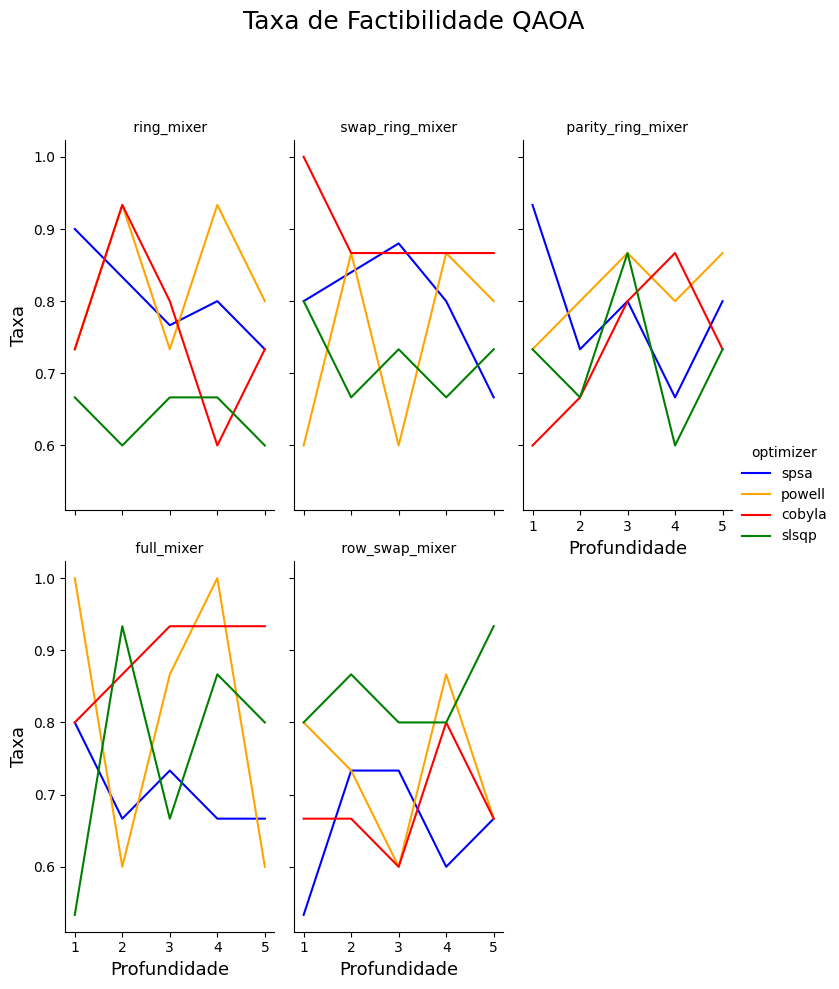

In [8]:
rel = sns.relplot(
    data=qaoa_feas_ratio,
    kind="line",
    x="depth",
    y="feasibility_ratio",
    col="mixer",
    hue="optimizer",
    aspect=.5,
    palette=custom_palette_opt,
    col_wrap=3
)

rel.fig.subplots_adjust(top=.85)
rel.fig.suptitle("Taxa de Factibilidade QAOA", fontsize=18)
rel.set_axis_labels("Profundidade", "Taxa", fontsize=13)
rel.set_titles(col_template=" {col_name} ", row_template=" {row_name} ", fontsize=12)

rel

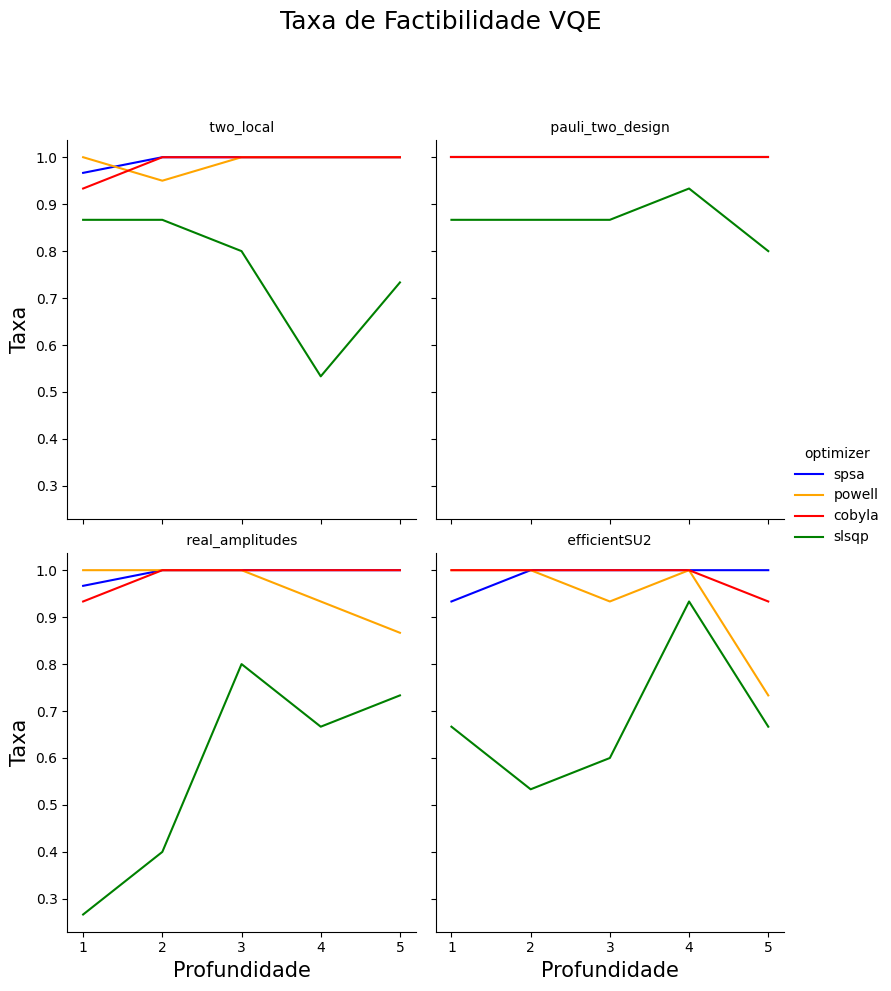

In [27]:
rel = sns.relplot(
    data=vqe_feas_ratio,
    kind="line",
    x="depth",
    y="feasibility_ratio",
    col="ansatz",
    hue="optimizer",
    aspect=.8,
    palette=custom_palette_opt,    
    col_wrap=2
)

rel.fig.subplots_adjust(top=.85)
rel.fig.suptitle("Taxa de Factibilidade VQE", fontsize=18)
rel.set_axis_labels("Profundidade", "Taxa", fontsize=15)
rel.set_titles(col_template=" {col_name} ", row_template=" {row_name} ", fontsize=12)

rel

## Custo

In [10]:
def create_cost_ratio(df):
    df_cost = df.copy().query("valid == 1")
    df_cost["cost_ratio"] = df_cost["optimal"] / df_cost["cost"]
    return df_cost

df_vqe_cost = create_cost_ratio(df_vqe)
df_qaoa_cost = create_cost_ratio(df_qaoa)

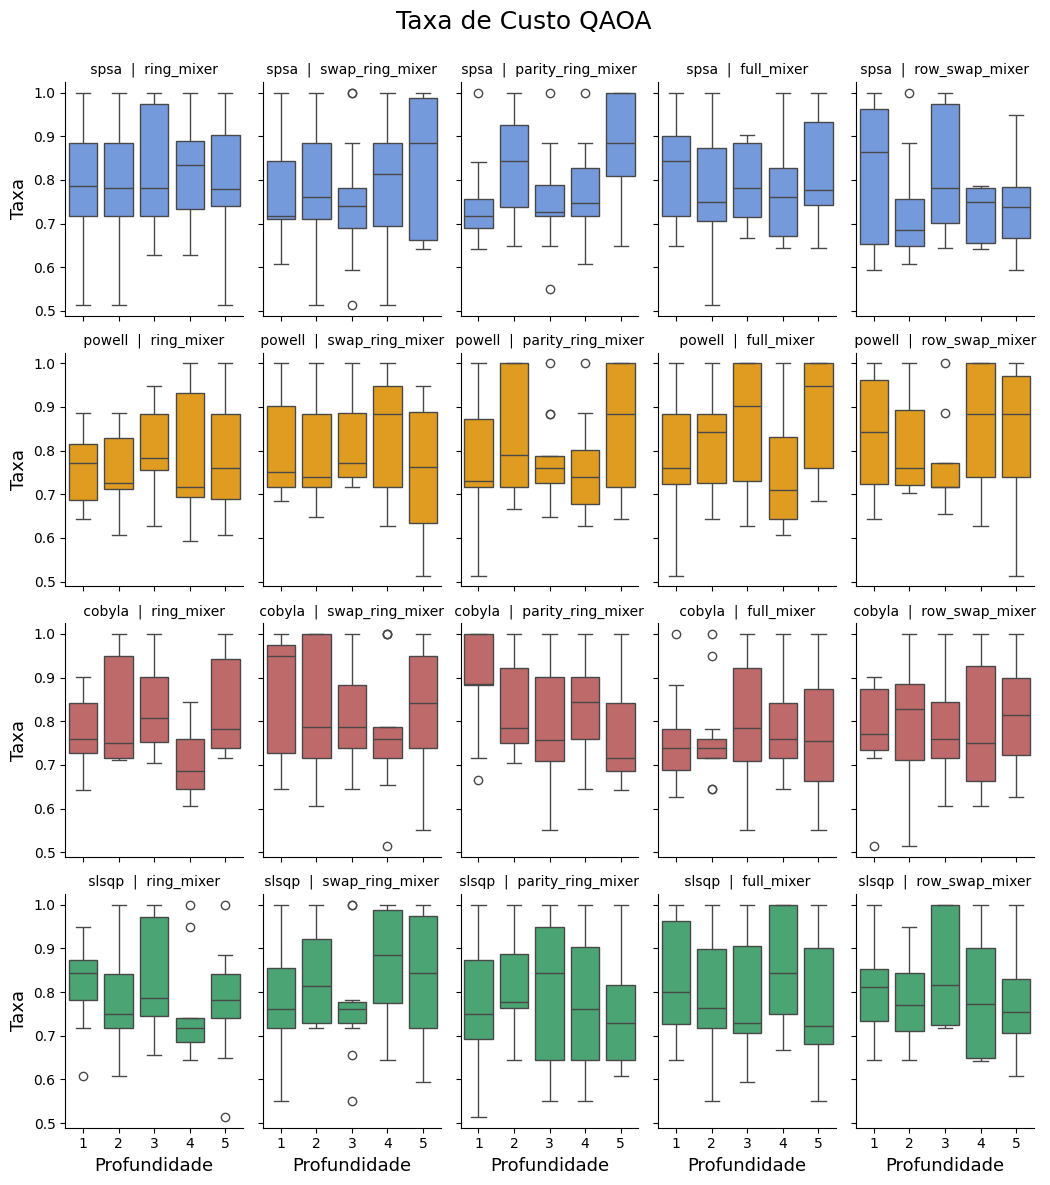

In [11]:
g = sns.FacetGrid(df_qaoa_cost, col="mixer", row="optimizer", aspect=0.7)
g.map_dataframe(sns.boxplot, x="depth", y="cost_ratio", hue="optimizer", palette=custom_palette_opt_light)
g.set_titles(col_template=" {col_name} ", row_template=" {row_name} ")
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle("Taxa de Custo QAOA", fontsize=18)
g.set_axis_labels("Profundidade", "Taxa", fontsize=13)

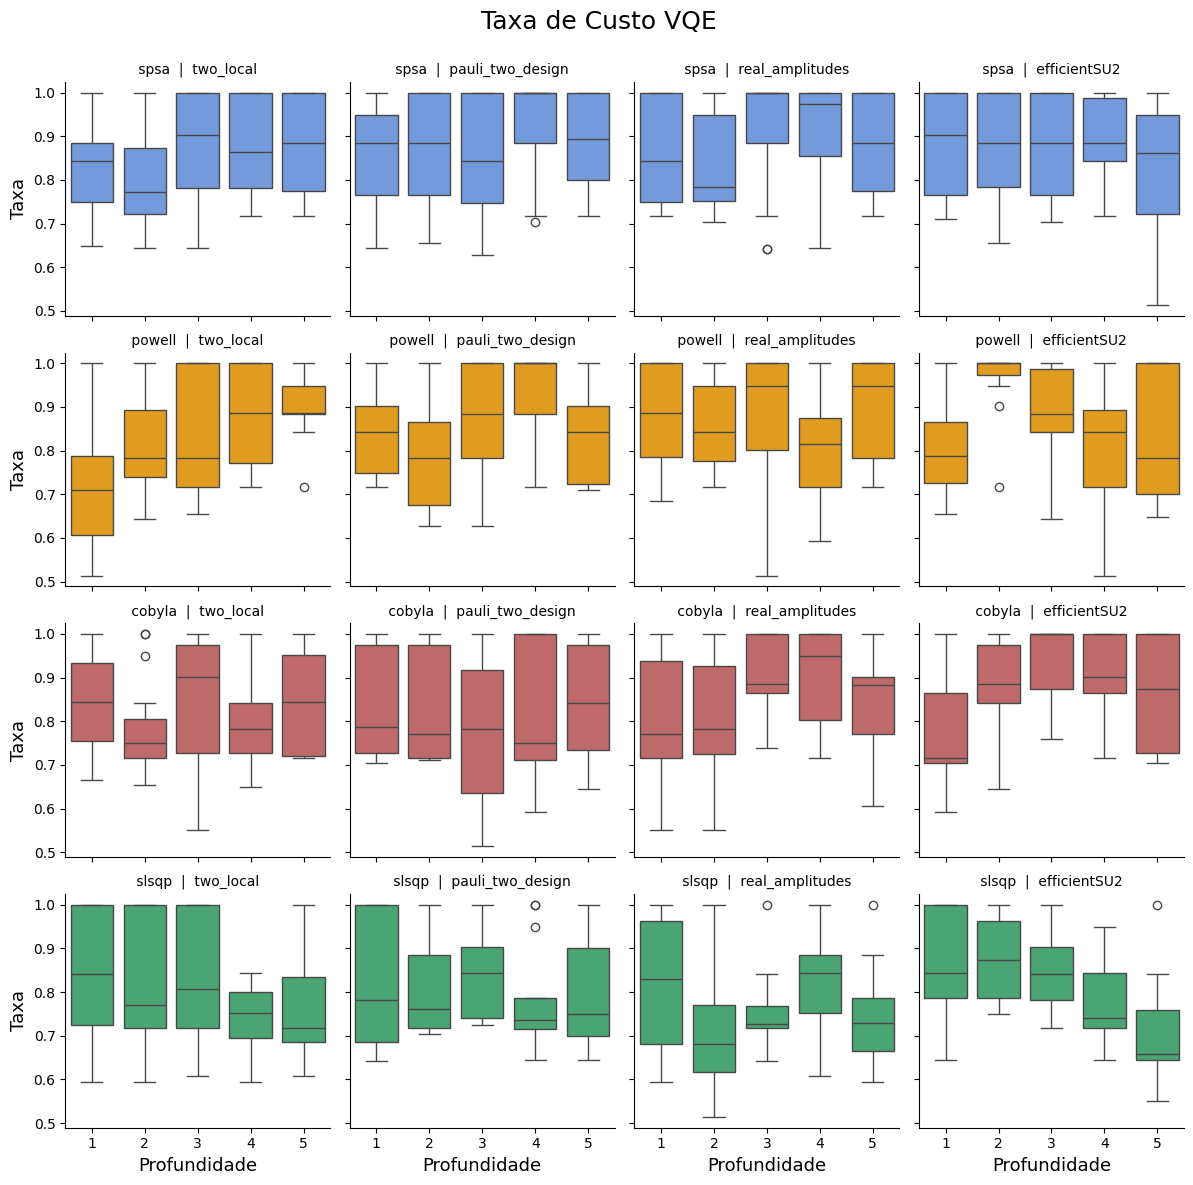

In [12]:
g = sns.FacetGrid(df_vqe_cost, col="ansatz", row="optimizer", aspect=1)
g.map_dataframe(sns.boxplot, x="depth", y="cost_ratio", hue="optimizer", palette=custom_palette_opt_light)
g.set_titles(col_template=" {col_name} ", row_template=" {row_name} ")
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle("Taxa de Custo VQE", fontsize=18)
g.set_axis_labels("Profundidade", "Taxa",fontsize=13)

In [13]:
def calculate_median_cost_ratio(df, vqa):
    circuit_type = "mixer" if vqa == "qaoa" else "ansatz"
    data = []
    for circuit in df[circuit_type].unique():
        df_circuit = df.query(f"{circuit_type} == '{circuit}'")
        for opt in df_circuit["optimizer"].unique():
            df_opt = df_circuit.query(f"optimizer == '{opt}'")
            for depth in df_opt["depth"].unique():
                df_depth = df_opt.query(f"depth == {depth}")
                data.append({
                    circuit_type: circuit,
                    "optimizer": opt,
                    "depth": depth,
                    "median_cost_ratio": sum(df_depth["cost_ratio"]) / len(df_depth)
                })
    return pd.DataFrame(data)

vqe_median_cost = calculate_median_cost_ratio(df_vqe_cost, "vqe")
qaoa_median_cost = calculate_median_cost_ratio(df_qaoa_cost, "qaoa")

In [14]:
vqe_median_cost.sort_values(by="median_cost_ratio", ascending=False).head(10)

,ansatz,optimizer,depth,median_cost_ratio
66,efficientSU2,powell,2,0.967790
72,efficientSU2,cobyla,3,0.933900
23,pauli_two_design,spsa,4,0.927379
42,real_amplitudes,spsa,3,0.919302
28,pauli_two_design,powell,4,0.917211
52,real_amplitudes,cobyla,3,0.916845
43,real_amplitudes,spsa,4,0.909710
9,two_local,powell,5,0.900315
53,real_amplitudes,cobyla,4,0.899910
73,efficientSU2,cobyla,4,0.899903


In [35]:
print(vqe_median_cost.sort_values(by="median_cost_ratio", ascending=False).head(10).to_latex())

\begin{tabular}{lllrr}
\toprule
 & ansatz & optimizer & depth & median_cost_ratio \\
\midrule
66 & efficientSU2 & powell & 2 & 0.967790 \\
72 & efficientSU2 & cobyla & 3 & 0.933900 \\
23 & pauli_two_design & spsa & 4 & 0.927379 \\
42 & real_amplitudes & spsa & 3 & 0.919302 \\
28 & pauli_two_design & powell & 4 & 0.917211 \\
52 & real_amplitudes & cobyla & 3 & 0.916845 \\
43 & real_amplitudes & spsa & 4 & 0.909710 \\
9 & two_local & powell & 5 & 0.900315 \\
53 & real_amplitudes & cobyla & 4 & 0.899910 \\
73 & efficientSU2 & cobyla & 4 & 0.899903 \\
\bottomrule
\end{tabular}



In [15]:
qaoa_median_cost.sort_values(by="median_cost_ratio", ascending=False).head(10)

,mixer,optimizer,depth,median_cost_ratio
50,parity_ring_mixer,cobyla,1,0.887398
69,full_mixer,powell,5,0.882823
30,swap_ring_mixer,cobyla,1,0.871923
44,parity_ring_mixer,spsa,5,0.869929
38,swap_ring_mixer,slsqp,4,0.865339
78,full_mixer,slsqp,4,0.864373
67,full_mixer,powell,3,0.863331
97,row_swap_mixer,slsqp,3,0.854785
88,row_swap_mixer,powell,4,0.843033
49,parity_ring_mixer,powell,5,0.840710


In [36]:
print(qaoa_median_cost.sort_values(by="median_cost_ratio", ascending=False).head(10).to_latex())

\begin{tabular}{lllrr}
\toprule
 & mixer & optimizer & depth & median_cost_ratio \\
\midrule
50 & parity_ring_mixer & cobyla & 1 & 0.887398 \\
69 & full_mixer & powell & 5 & 0.882823 \\
30 & swap_ring_mixer & cobyla & 1 & 0.871923 \\
44 & parity_ring_mixer & spsa & 5 & 0.869929 \\
38 & swap_ring_mixer & slsqp & 4 & 0.865339 \\
78 & full_mixer & slsqp & 4 & 0.864373 \\
67 & full_mixer & powell & 3 & 0.863331 \\
97 & row_swap_mixer & slsqp & 3 & 0.854785 \\
88 & row_swap_mixer & powell & 4 & 0.843033 \\
49 & parity_ring_mixer & powell & 5 & 0.840710 \\
\bottomrule
\end{tabular}



In [16]:
# rel = sns.relplot(
#     data=vqe_median_cost,
#     kind="line",
#     x="depth",
#     y="median_cost_ratio",
#     col="ansatz",
#     hue="optimizer",
#     aspect=.6,
#     palette=custom_palette_opt
# )

# rel.fig.subplots_adjust(top=.85)
# rel.fig.suptitle("VQE média do custo de rota", fontsize=18)
# rel.set_axis_labels("Profundidade", "Taxa", fontsize=13)

# rel

In [17]:
# rel = sns.relplot(
#     data=qaoa_median_cost,
#     kind="line",
#     x="depth",
#     y="median_cost_ratio",
#     col="mixer",
#     hue="optimizer",
#     aspect=.55,
#     palette=custom_palette_opt
# )

# rel.fig.subplots_adjust(top=.85)
# rel.fig.suptitle("QAOA média do custo da rota", fontsize=18)
# rel.set_axis_labels("Profundidade", "Taxa", fontsize=13)

# rel

## Tempo de execução

In [18]:
def calculate_median_execution_time(df, vqa):
    circuit_type = "mixer" if vqa == "qaoa" else "ansatz"
    data = []
    for circuit in df[circuit_type].unique():
        df_circuit = df.query(f"{circuit_type} == '{circuit}'")
        for opt in df_circuit["optimizer"].unique():
            df_opt = df_circuit.query(f"optimizer == '{opt}'")
            for depth in df_opt["depth"].unique():
                df_depth = df_opt.query(f"depth == {depth}")
                data.append(
                    {
                        circuit_type: circuit,
                        "optimizer": opt,
                        "depth": depth,
                        "median_exec_time": sum(df_depth["time_sec"]) / len(df_depth),
                    }
                )
    return pd.DataFrame(data)


vqe_median_exec_time = calculate_median_execution_time(df_vqe, "vqe")
qaoa_median_exec_time = calculate_median_execution_time(df_qaoa, "qaoa")

In [19]:
vqe_median_exec_time.sort_values(by="median_exec_time", ascending=False).head(10)

,ansatz,optimizer,depth,median_exec_time
19,two_local,slsqp,5,32402.741371
18,two_local,slsqp,4,19944.147625
39,pauli_two_design,slsqp,5,18062.239082
38,pauli_two_design,slsqp,4,16260.912398
17,two_local,slsqp,3,13141.624932
37,pauli_two_design,slsqp,3,12984.344041
16,two_local,slsqp,2,12255.146770
36,pauli_two_design,slsqp,2,7331.701034
15,two_local,slsqp,1,6534.633449
35,pauli_two_design,slsqp,1,5113.070008


In [37]:
print(vqe_median_exec_time.sort_values(by="median_exec_time", ascending=False).head(10).to_latex())

\begin{tabular}{lllrr}
\toprule
 & ansatz & optimizer & depth & median_exec_time \\
\midrule
19 & two_local & slsqp & 5 & 32402.741371 \\
18 & two_local & slsqp & 4 & 19944.147625 \\
39 & pauli_two_design & slsqp & 5 & 18062.239082 \\
38 & pauli_two_design & slsqp & 4 & 16260.912398 \\
17 & two_local & slsqp & 3 & 13141.624932 \\
37 & pauli_two_design & slsqp & 3 & 12984.344041 \\
16 & two_local & slsqp & 2 & 12255.146770 \\
36 & pauli_two_design & slsqp & 2 & 7331.701034 \\
15 & two_local & slsqp & 1 & 6534.633449 \\
35 & pauli_two_design & slsqp & 1 & 5113.070008 \\
\bottomrule
\end{tabular}



In [20]:
qaoa_median_exec_time.sort_values(by="median_exec_time", ascending=False).head(10)

,mixer,optimizer,depth,median_exec_time
99,row_swap_mixer,slsqp,5,2833.773995
98,row_swap_mixer,slsqp,4,1872.781937
89,row_swap_mixer,powell,5,1401.255814
39,swap_ring_mixer,slsqp,5,1355.402226
19,ring_mixer,slsqp,5,1324.462242
79,full_mixer,slsqp,5,1273.400639
97,row_swap_mixer,slsqp,3,1271.321613
88,row_swap_mixer,powell,4,1243.601058
59,parity_ring_mixer,slsqp,5,1165.435768
84,row_swap_mixer,spsa,5,1134.902551


In [38]:
print(qaoa_median_exec_time.sort_values(by="median_exec_time", ascending=False).head(10).to_latex())

\begin{tabular}{lllrr}
\toprule
 & mixer & optimizer & depth & median_exec_time \\
\midrule
99 & row_swap_mixer & slsqp & 5 & 2833.773995 \\
98 & row_swap_mixer & slsqp & 4 & 1872.781937 \\
89 & row_swap_mixer & powell & 5 & 1401.255814 \\
39 & swap_ring_mixer & slsqp & 5 & 1355.402226 \\
19 & ring_mixer & slsqp & 5 & 1324.462242 \\
79 & full_mixer & slsqp & 5 & 1273.400639 \\
97 & row_swap_mixer & slsqp & 3 & 1271.321613 \\
88 & row_swap_mixer & powell & 4 & 1243.601058 \\
59 & parity_ring_mixer & slsqp & 5 & 1165.435768 \\
84 & row_swap_mixer & spsa & 5 & 1134.902551 \\
\bottomrule
\end{tabular}



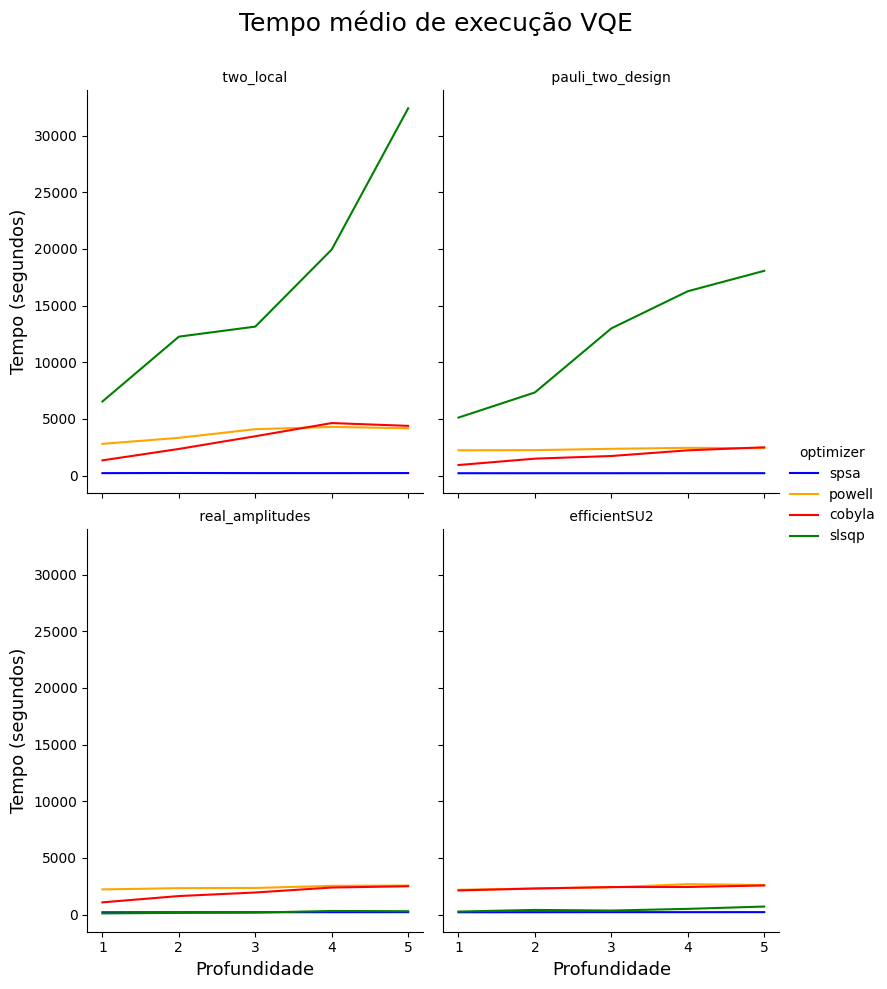

In [26]:
rel = sns.relplot(
    data=vqe_median_exec_time,
    kind="line",
    x="depth",
    y="median_exec_time",
    col="ansatz",
    hue="optimizer",
    aspect=.8,
    palette=custom_palette_opt,
    col_wrap=2
)

rel.fig.subplots_adjust(top=.9)
rel.fig.suptitle("Tempo médio de execução VQE", fontsize=18)
rel.set_axis_labels("Profundidade", "Tempo (segundos)", fontsize=13)
rel.set_titles(col_template=" {col_name} ", row_template=" {row_name} ", fontsize=12)

rel

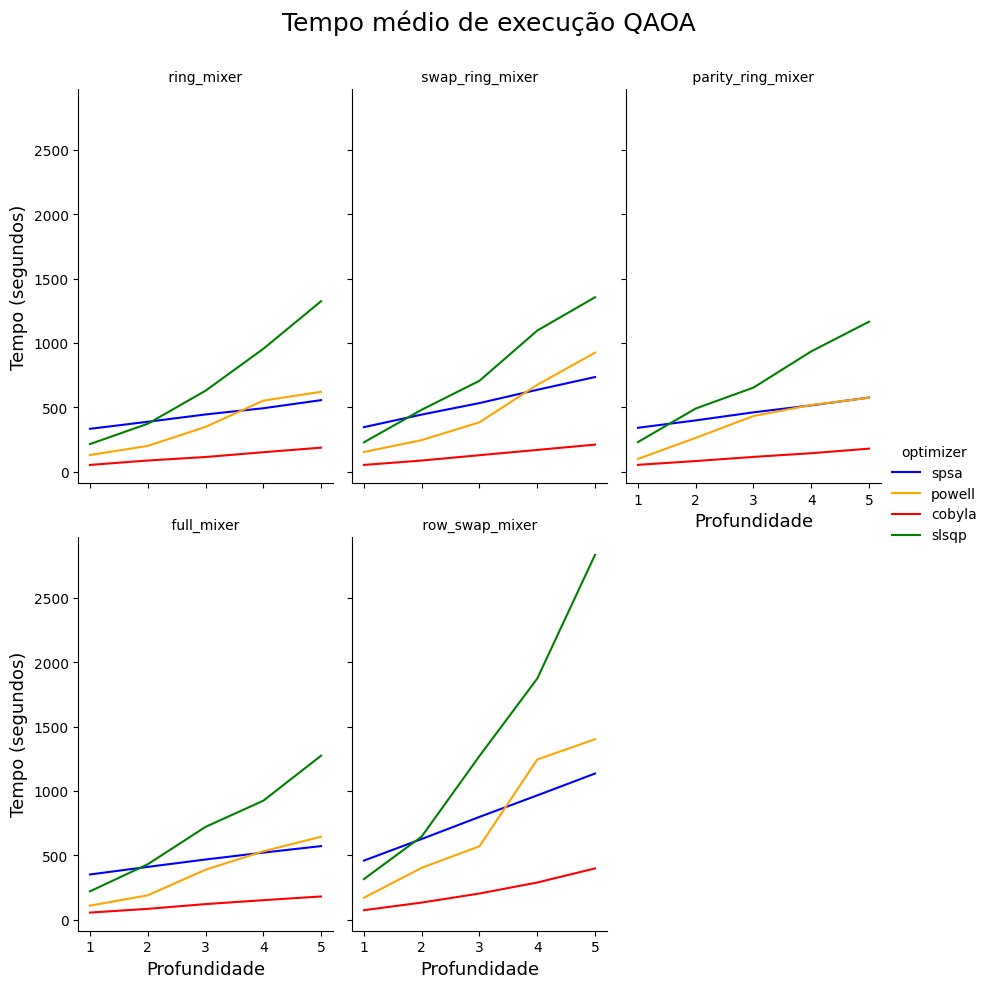

In [22]:
rel = sns.relplot(
    data=qaoa_median_exec_time,
    kind="line",
    x="depth",
    y="median_exec_time",
    col="mixer",
    hue="optimizer",
    aspect=.6,
    palette=custom_palette_opt,
    col_wrap=3
)

rel.fig.subplots_adjust(top=.9)
rel.fig.suptitle("Tempo médio de execução QAOA",fontsize=18)
rel.set_axis_labels("Profundidade", "Tempo (segundos)", fontsize=13)
rel.set_titles(col_template=" {col_name} ", row_template=" {row_name} ", fontsize=12)

rel

# Soluções inválidas

In [23]:
def calculate_invalid_solutions(df, vqa):
    circuit_type = "mixer" if vqa == "qaoa" else "ansatz"
    data = []
    for circuit in df[circuit_type].unique():
        df_circuit = df.query(f"{circuit_type} == '{circuit}'")
        for opt in df_circuit["optimizer"].unique():
            df_opt = df_circuit.query(f"optimizer == '{opt}'")
            for depth in df_opt["depth"].unique():
                df_depth = df_opt.query(f"depth == {depth}")
                data.append(
                    {
                        circuit_type: circuit,
                        "optimizer": opt,
                        "depth": depth,
                        "invalid_solutions": len(df_depth.query("valid == 0")),
                    }
                )
    return pd.DataFrame(data)

vqe_invalid = calculate_invalid_solutions(df_vqe, "vqe")
qaoa_invalid = calculate_invalid_solutions(df_qaoa, "qaoa")

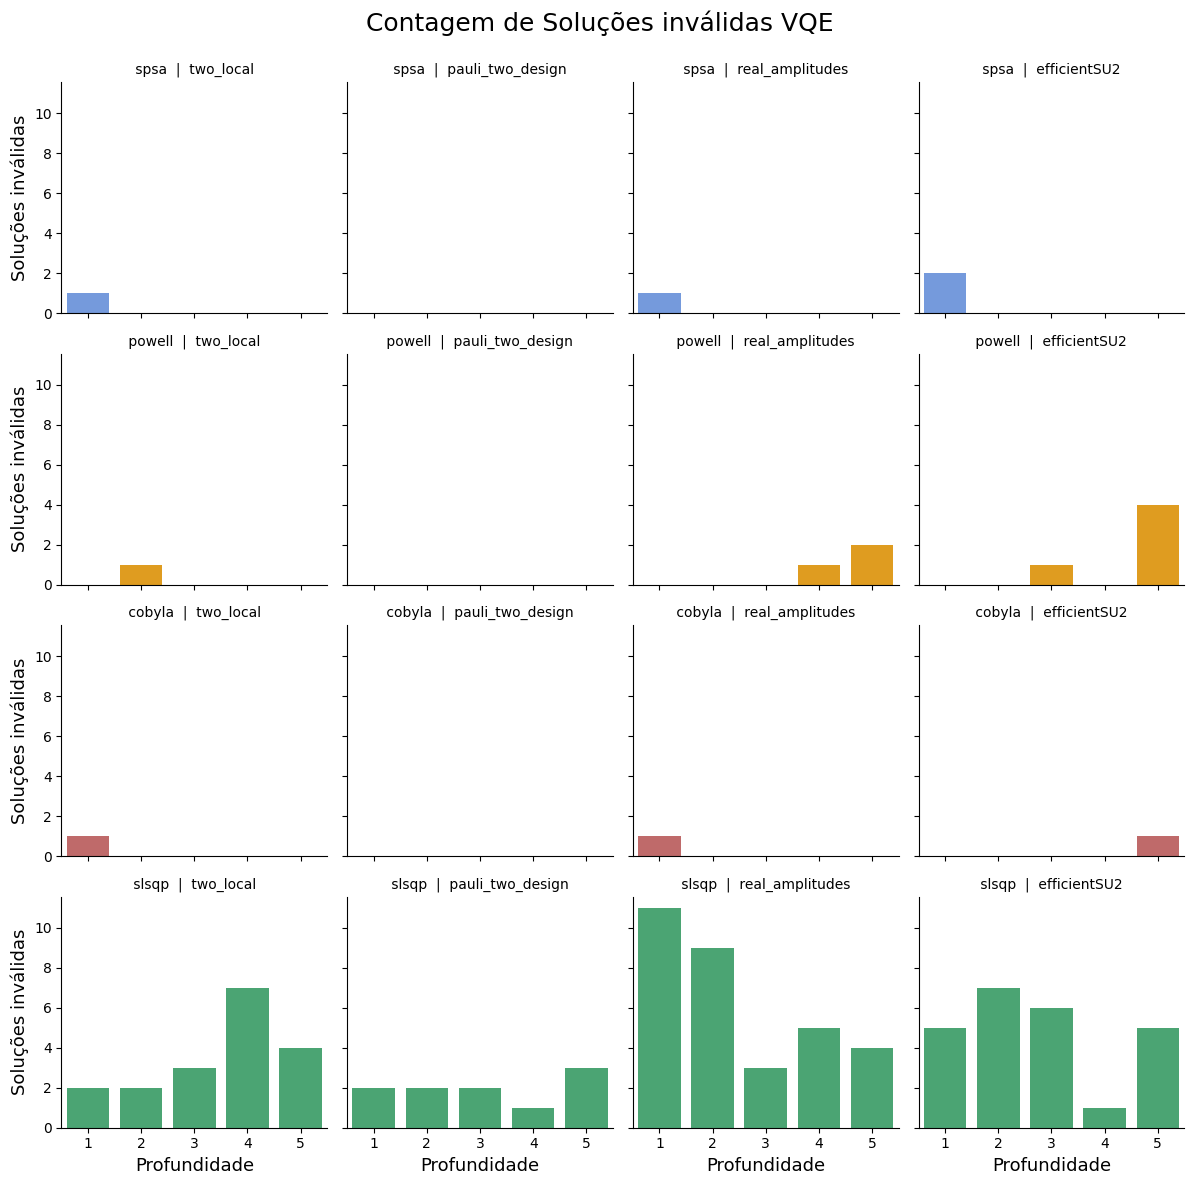

In [24]:
g = sns.FacetGrid(vqe_invalid, col="ansatz", row="optimizer", aspect=1)
g.map_dataframe(sns.barplot, x="depth", y="invalid_solutions", hue="optimizer", palette=custom_palette_opt_light)
g.set_titles(col_template=" {col_name} ", row_template=" {row_name} ")
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle("Contagem de Soluções inválidas VQE", fontsize=18)
g.set_axis_labels("Profundidade", "Soluções inválidas", fontsize=13)

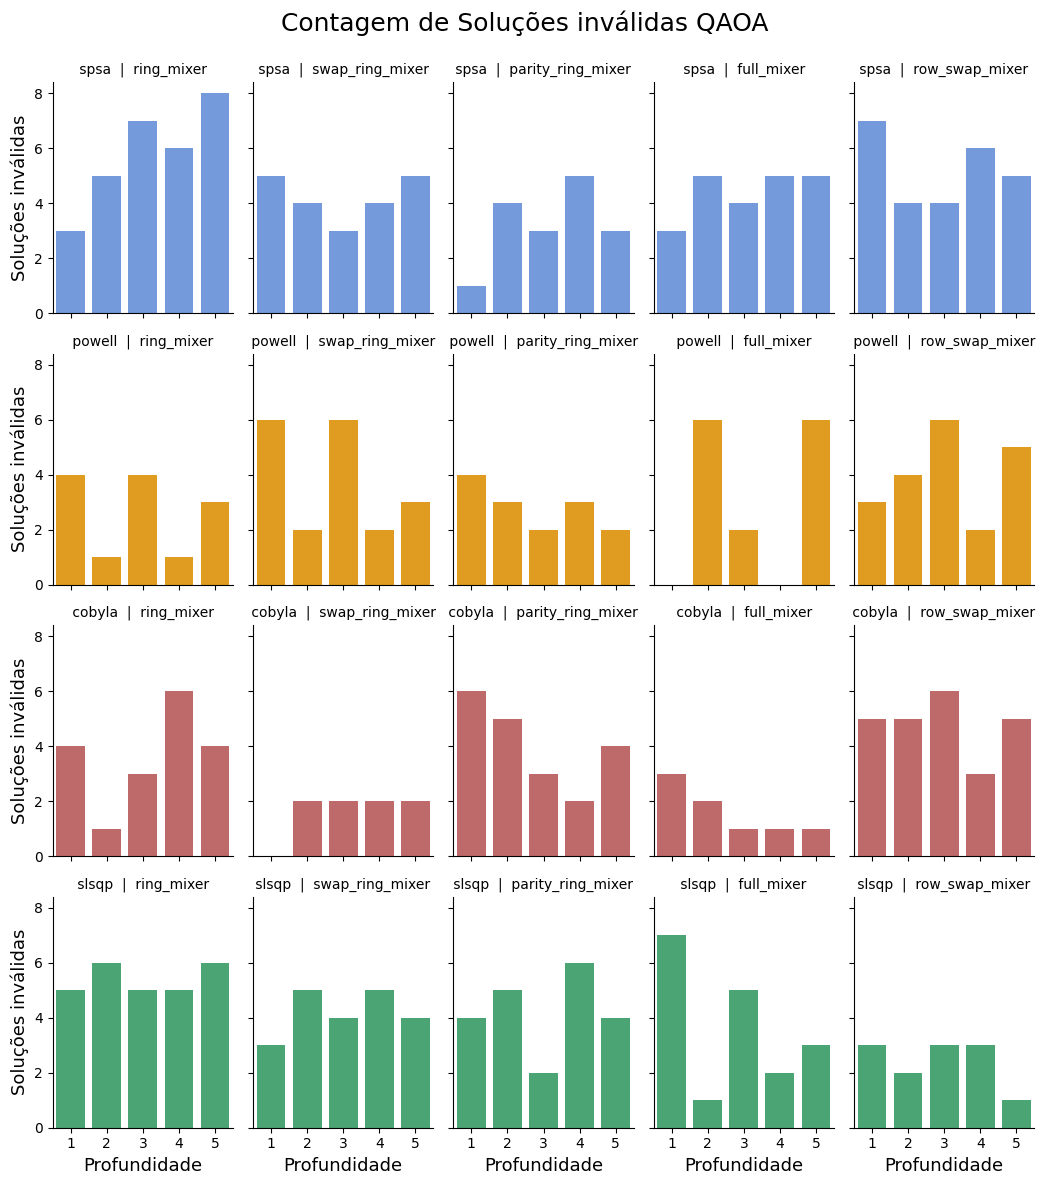

In [25]:
g = sns.FacetGrid(qaoa_invalid, col="mixer", row="optimizer", aspect=0.7)
g.map_dataframe(sns.barplot, x="depth", y="invalid_solutions", hue="optimizer", palette=custom_palette_opt_light)
g.set_titles(col_template=" {col_name} ", row_template=" {row_name} ")
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle("Contagem de Soluções inválidas QAOA", fontsize=18)
g.set_axis_labels("Profundidade", "Soluções inválidas", fontsize=13)